# Init

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
import matplotlib.pyplot as plt

logger = logging.getLogger("beta2")


## Load data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [14]:
feature_type = "contacts_5_cutoff" # "contacts_5_cutoff" or "CA_inv"
working_dir = os.path.expanduser("~/projects/gpcr/mega/Result_Data/beta2-dror/clustering/{}/".format(feature_type))
raw_data = np.load(working_dir + "samples.npy")
scale_data = True
cluster_indices = np.loadtxt(working_dir + 'cluster_indices_.txt')
data = utils.vectorize(raw_data)  # Our training data to classifiers
labels = utils.create_class_labels(cluster_indices)  #Our training labels to classifiers
feature_to_resids = np.load(
    working_dir + "feature_to_resids.npy")  #Mapping from residue Id to the index of that residue in the data (for proteins with missing residues)
if len(data) != len(labels) or data.shape[1] != len(feature_to_resids):
    raise Exception()
logger.info("Loaded data of shape %s and %s clusters", data.shape, len(set(cluster_indices)))


2018-11-01 16:34:35 beta2-INFO: Loaded data of shape (857, 39903) and 3 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [15]:
n_iterations, n_splits = 4, 4
feature_extractors = [
    fe.MlpFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations, hidden_layer_sizes=(100, 50, 25)),
    fe.ElmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.KLFeatureExtractor(data, labels, n_splits=n_splits),
    fe.PCAFeatureExtractor(data, labels, n_splits=n_splits),
    fe.RandomForestFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-11-01 16:34:35 beta2-INFO: Done. using 5 feature extractors


# Run the relevance analysis

In [16]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2018-11-01 16:34:35 beta2-INFO: Computing relevance for extractors MLP
2018-11-01 16:34:39 Extracting feature-DEBUG: Iteration 1 of 16
2018-11-01 16:35:00 Extracting feature-DEBUG: Error: 62.9457364341
2018-11-01 16:35:00 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-11-01 16:35:00 Extracting feature-DEBUG: Iteration 2 of 16
2018-11-01 16:35:20 Extracting feature-DEBUG: Error: 62.9457364341
2018-11-01 16:35:20 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-11-01 16:35:20 Extracting feature-DEBUG: Iteration 3 of 16
2018-11-01 16:35:43 Extracting feature-DEBUG: Error: 62.9457364341
2018-11-01 16:35:43 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-11-01 16:35:43 Extracting feature-DEBUG: Iteration 4 of 16
2018-11-01 16:35:55 Extracting feature-DEBUG: Error: 62.7906976744
2018-11-01 16:35:55 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-11-0

2018-11-01 16:43:28 Extracting feature-DEBUG: Error: 7.78816199377
2018-11-01 16:43:28 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-11-01 16:43:28 Extracting feature-DEBUG: Iteration 16 of 16
2018-11-01 16:43:29 elm-INFO: Automatically settings number of nodes in first layer to 4000
2018-11-01 16:43:36 Extracting feature-DEBUG: Error: 7.47663551402
2018-11-01 16:43:36 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-11-01 16:43:36 beta2-INFO: Computing relevance for extractors KL
2018-11-01 16:43:40 Extracting feature-DEBUG: Iteration 1 of 4
2018-11-01 16:43:43 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-01 16:43:43 Extracting feature-DEBUG: Iteration 2 of 4
2018-11-01 16:43:46 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-01 16:43:46 Extracting feature-DEBUG: Iteration 3 of 4
2018-11-01 16:43:49 Extracting feature-DEBUG: Computing feature importance o

modules/postprocessing.py:187: RuntimeWarning: invalid value encountered in true_divide
  relevances[:,i] = (relevances[:,i] - offset)/scale


2018-11-01 16:43:57 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-01 16:43:57 PCA featurizer-INFO: Selecting 156 components
2018-11-01 16:43:57 Extracting feature-DEBUG: Iteration 2 of 4
2018-11-01 16:43:57 PCA featurizer-INFO: Training PCA
2018-11-01 16:44:03 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-01 16:44:03 PCA featurizer-INFO: Selecting 149 components
2018-11-01 16:44:03 Extracting feature-DEBUG: Iteration 3 of 4
2018-11-01 16:44:03 PCA featurizer-INFO: Training PCA
2018-11-01 16:44:10 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-01 16:44:10 PCA featurizer-INFO: Selecting 152 components
2018-11-01 16:44:10 Extracting feature-DEBUG: Iteration 4 of 4
2018-11-01 16:44:10 PCA featurizer-INFO: Training PCA
2018-11-01 16:44:15 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-01 16:44:15 PCA featurizer-INFO: Selecting 149 components
2018-11-01 16:44:15 beta2-INFO: C

# Remap and persist results 

In [17]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir, feature_to_resids=feature_to_resids)
    p.average()
    p.persist()
    postprocessors.append(p)

logger.info("Done")


2018-11-01 16:44:41 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:41 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:41 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:41 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:42 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:42 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:42 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:42 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:43 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:43 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:43 postprocessing-WARNING: importance is None for residues set([130])
2018-11-01 16:44:43 postprocessing-WARNING:

# Visualize results

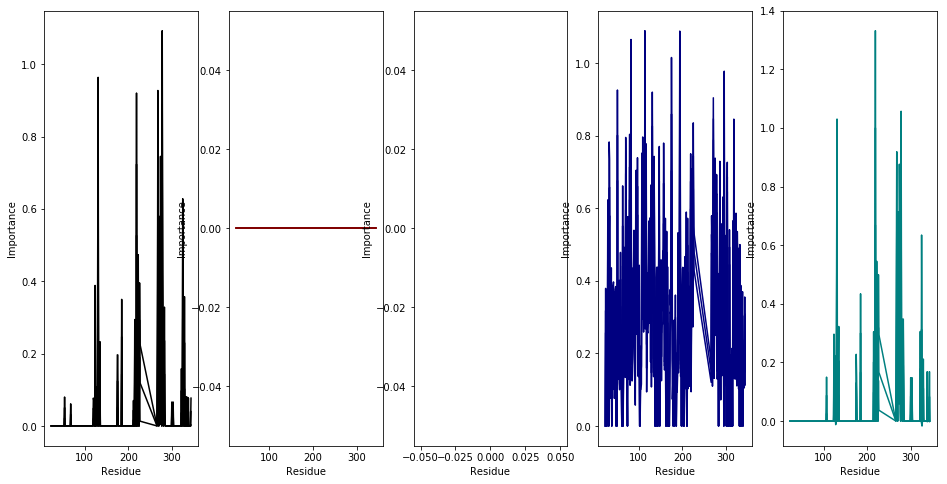

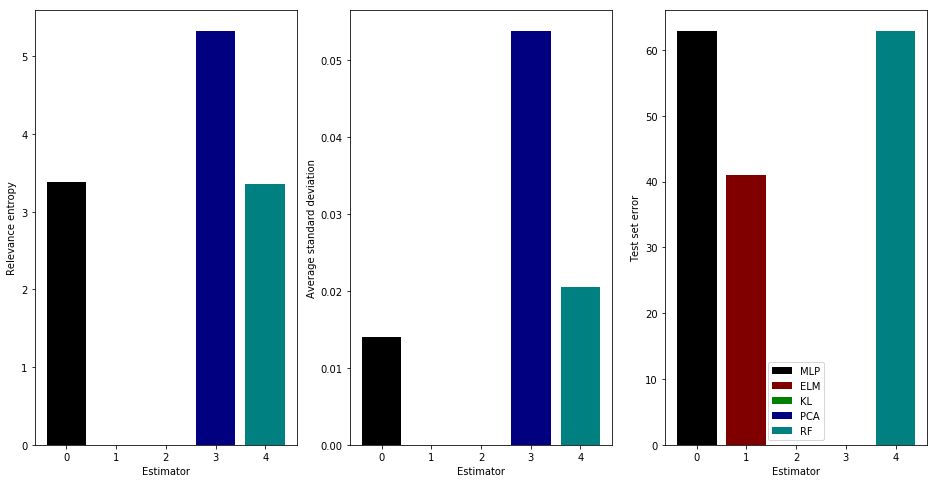

2018-11-01 17:47:01 beta2-INFO: Done


In [19]:
visualization.visualize(postprocessors)
logger.info("Done")